# Sparkify Project Workspace
This workspace contains a tiny subset (128MB) of the full dataset available (12GB). Feel free to use this workspace to build your project, or to explore a smaller subset with Spark before deploying your cluster on the cloud. Instructions for setting up your Spark cluster is included in the last lesson of the Extracurricular Spark Course content.

You can follow the steps below to guide your data analysis and model building portion of this project.

In [3]:
from pyspark.sql import SparkSession
from pyspark.sql.functions import round, sum, avg,count, countDistinct, col, concat, desc, explode, last, lit, min, max, split, udf, when, isnan
from pyspark.sql.types import IntegerType
from pyspark.sql.window import Window

from pyspark.ml.classification import LogisticRegression, RandomForestClassifier, GBTClassifier
from pyspark.ml.evaluation import MulticlassClassificationEvaluator
from pyspark.ml.feature import CountVectorizer, IDF, Normalizer, PCA, RegexTokenizer, StandardScaler, StopWordsRemover, StringIndexer, VectorAssembler, OneHotEncoder
from pyspark.ml.regression import LinearRegression
from pyspark.ml.tuning import CrossValidator, ParamGridBuilder
from pyspark.ml import Pipeline
from pyspark.ml.evaluation import BinaryClassificationEvaluator
from pyspark.mllib.evaluation import MulticlassMetrics

import re

In [4]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

In [5]:
spark = SparkSession.builder \
    .master("local") \
    .appName("Datascience Capstone Project") \
    .getOrCreate()

# Load and Clean Dataset
In this workspace, the mini-dataset file is `mini_sparkify_event_data.json`. Load and clean the dataset, checking for invalid or missing data - for example, records without userids or sessionids. 

In [6]:
#event_data = spark.read.json("mini_sparkify_event_data.json")
event_data = spark.read.json("medium-sparkify-event-data.json")

In [7]:
event_data.printSchema()

root
 |-- artist: string (nullable = true)
 |-- auth: string (nullable = true)
 |-- firstName: string (nullable = true)
 |-- gender: string (nullable = true)
 |-- itemInSession: long (nullable = true)
 |-- lastName: string (nullable = true)
 |-- length: double (nullable = true)
 |-- level: string (nullable = true)
 |-- location: string (nullable = true)
 |-- method: string (nullable = true)
 |-- page: string (nullable = true)
 |-- registration: long (nullable = true)
 |-- sessionId: long (nullable = true)
 |-- song: string (nullable = true)
 |-- status: long (nullable = true)
 |-- ts: long (nullable = true)
 |-- userAgent: string (nullable = true)
 |-- userId: string (nullable = true)



In [8]:
event_data = event_data.where(col('userId') != '')

In [9]:
event_data.select([count(when(isnan(c) | col(c).isNull(), c)).alias(c) for c in event_data.columns]).show()

+------+----+---------+------+-------------+--------+------+-----+--------+------+----+------------+---------+-----+------+---+---------+------+
|artist|auth|firstName|gender|itemInSession|lastName|length|level|location|method|page|registration|sessionId| song|status| ts|userAgent|userId|
+------+----+---------+------+-------------+--------+------+-----+--------+------+----+------------+---------+-----+------+---+---------+------+
| 95128|   0|        0|     0|            0|       0| 95128|    0|       0|     0|   0|           0|        0|95128|     0|  0|        0|     0|
+------+----+---------+------+-------------+--------+------+-----+--------+------+----+------------+---------+-----+------+---+---------+------+



In [10]:
event_data.where(event_data.song.isNull()).select(event_data.page).distinct().show(100)
# This is due to the fact that only when the users click on NextSong, there is an Artist/Length or Song saved in the database

+--------------------+
|                page|
+--------------------+
|              Cancel|
|    Submit Downgrade|
|         Thumbs Down|
|                Home|
|           Downgrade|
|         Roll Advert|
|              Logout|
|       Save Settings|
|Cancellation Conf...|
|               About|
|            Settings|
|     Add to Playlist|
|          Add Friend|
|           Thumbs Up|
|                Help|
|             Upgrade|
|               Error|
|      Submit Upgrade|
+--------------------+



In [11]:
event_data.where(event_data.song.isNotNull()).select(event_data.page).distinct().show(100)

+--------+
|    page|
+--------+
|NextSong|
+--------+



We still have null values on artist, song and length because in those cases the action of the user was not related to a song, as shown in the previous cell.

# Exploratory Data Analysis
When you're working with the full dataset, perform EDA by loading a small subset of the data and doing basic manipulations within Spark. In this workspace, you are already provided a small subset of data you can explore.

In [12]:
event_data.summary().show()

+-------+-----------------+---------+---------+------+------------------+--------+------------------+------+----------------+------+-------+--------------------+------------------+--------------------+------------------+--------------------+--------------------+------------------+
|summary|           artist|     auth|firstName|gender|     itemInSession|lastName|            length| level|        location|method|   page|        registration|         sessionId|                song|            status|                  ts|           userAgent|            userId|
+-------+-----------------+---------+---------+------+------------------+--------+------------------+------+----------------+------+-------+--------------------+------------------+--------------------+------------------+--------------------+--------------------+------------------+
|  count|           432877|   528005|   528005|528005|            528005|  528005|            432877|528005|          528005|528005| 528005|              

In [13]:
event_data.take(1)

[Row(artist='Martin Orford', auth='Logged In', firstName='Joseph', gender='M', itemInSession=20, lastName='Morales', length=597.55057, level='free', location='Corpus Christi, TX', method='PUT', page='NextSong', registration=1532063507000, sessionId=292, song='Grand Designs', status=200, ts=1538352011000, userAgent='"Mozilla/5.0 (Macintosh; Intel Mac OS X 10_9_4) AppleWebKit/537.36 (KHTML, like Gecko) Chrome/36.0.1985.125 Safari/537.36"', userId='293')]

In [14]:
print("Number of rows of this subset: ")
event_data.count()

Number of rows of this subset: 


528005

In [15]:
print("Number of Users in this subset: ")
event_data.select("userId").distinct().count()

Number of Users in this subset: 


448

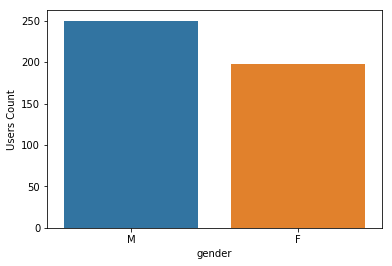

In [16]:
gender_count = event_data.groupby('gender').agg(countDistinct("userId").alias("Users Count")).sort(col('Users Count').desc())
sns.barplot(x='gender',y='Users Count',data=gender_count.toPandas());

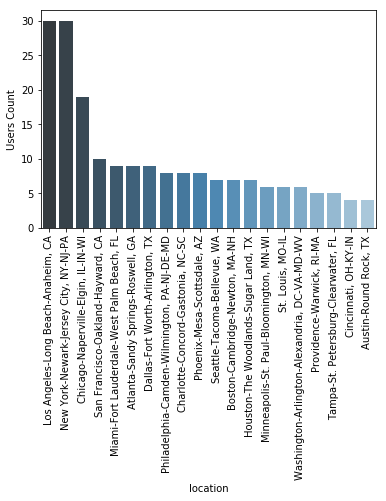

In [17]:
location_count = event_data.groupby('location').agg(countDistinct("userId").alias("Users Count")).sort(col('Users Count').desc()).limit(20)
location_plot = sns.barplot(x='location',y='Users Count',data=location_count.toPandas(), palette="Blues_d")
for item in location_plot.get_xticklabels():
    item.set_rotation(90)

In [18]:
print("List of different types of pages: ")
event_data.select(['page']).sort('page').distinct().show(23, False)

List of different types of pages: 
+-------------------------+
|page                     |
+-------------------------+
|About                    |
|Add Friend               |
|Add to Playlist          |
|Cancel                   |
|Cancellation Confirmation|
|Downgrade                |
|Error                    |
|Help                     |
|Home                     |
|Logout                   |
|NextSong                 |
|Roll Advert              |
|Save Settings            |
|Settings                 |
|Submit Downgrade         |
|Submit Upgrade           |
|Thumbs Down              |
|Thumbs Up                |
|Upgrade                  |
+-------------------------+



In [19]:
print("Number of sessions per user, ordered by sessions count: ")
event_data.groupby('userId').agg(count("sessionId").alias("sessionId Count")).sort(col('sessionId Count').desc()).show()

Number of sessions per user, ordered by sessions count: 
+------+---------------+
|userId|sessionId Count|
+------+---------------+
|    92|           9767|
|   140|           7448|
|300049|           7309|
|   101|           6842|
|300035|           6810|
|   195|           6184|
|   230|           6019|
|   163|           5965|
|   250|           5678|
|    18|           5511|
|   276|           5346|
|300017|           5266|
|    87|           5243|
|   293|           5125|
|300021|           5076|
|    42|           4952|
|300011|           4816|
|    30|           4737|
|    12|           4232|
|300031|           4194|
+------+---------------+
only showing top 20 rows



### Define Churn

Once you've done some preliminary analysis, create a column `Churn` to use as the label for your model. I suggest using the `Cancellation Confirmation` events to define your churn, which happen for both paid and free users. As a bonus task, you can also look into the `Downgrade` events.

In [20]:
churn_flag = udf(lambda x: 1 if x == 'Cancellation Confirmation' else 0, IntegerType())

event_data = event_data.withColumn("churn_flag", churn_flag('page'))

user_window = Window \
    .partitionBy('userId')

event_data = event_data.withColumn("churn", max(event_data.churn_flag).over(user_window))

### Explore Data
Once you've defined churn, perform some exploratory data analysis to observe the behavior for users who stayed vs users who churned. You can start by exploring aggregates on these two groups of users, observing how much of a specific action they experienced per a certain time unit or number of songs played.

In [21]:
event_data.groupby('churn').agg(countDistinct('userId').alias("Users Count")).show()

+-----+-----------+
|churn|Users Count|
+-----+-----------+
|    1|         99|
|    0|        349|
+-----+-----------+



In [22]:
event_data.groupby('gender', 'churn').agg(countDistinct("userId").alias("Users Count")).sort(col('Users Count').desc()).show()

+------+-----+-----------+
|gender|churn|Users Count|
+------+-----+-----------+
|     M|    0|        196|
|     F|    0|        153|
|     M|    1|         54|
|     F|    1|         45|
+------+-----+-----------+



In [23]:
event_data.groupby('level', 'churn').agg(countDistinct("userId").alias("Users Count")).sort(col('Users Count').desc()).show()

+-----+-----+-----------+
|level|churn|Users Count|
+-----+-----+-----------+
| free|    0|        288|
| paid|    0|        246|
| free|    1|         82|
| paid|    1|         75|
+-----+-----+-----------+



The same user can pass from free to paid or from paid to free, so the total counts exceed the total number of users in the dataset

In [24]:
event_data.groupby('auth', 'churn').agg(countDistinct("userId").alias("Users Count")).sort(col('Users Count').desc()).show()

+---------+-----+-----------+
|     auth|churn|Users Count|
+---------+-----+-----------+
|Logged In|    0|        349|
|Cancelled|    1|         99|
|Logged In|    1|         99|
+---------+-----+-----------+



Of course the users who churned are not anymore logged in and they end up in "Cancelled" type of authentication

In [25]:
event_data.groupby('status', 'churn').agg(countDistinct("userId").alias("Users Count")).sort(col('Users Count').desc()).show()

+------+-----+-----------+
|status|churn|Users Count|
+------+-----+-----------+
|   200|    0|        349|
|   307|    0|        347|
|   404|    0|        183|
|   307|    1|         99|
|   200|    1|         99|
|   404|    1|         40|
+------+-----+-----------+



Ratio for Users Count churn or not-churn does not seem to be affected by status

# Feature Engineering
Once you've familiarized yourself with the data, build out the features you find promising to train your model on. To work with the full dataset, you can follow the following steps.
- Write a script to extract the necessary features from the smaller subset of data
- Ensure that your script is scalable, using the best practices discussed in Lesson 3
- Try your script on the full data set, debugging your script if necessary

If you are working in the classroom workspace, you can just extract features based on the small subset of data contained here. Be sure to transfer over this work to the larger dataset when you work on your Spark cluster.

### Categorical Features

In [26]:
event_data_agg = event_data.select(["userId", "gender"]).distinct()

stringIndexer = StringIndexer(inputCol="gender", outputCol="genderIndexed")
stringIndexer = stringIndexer.fit(event_data_agg)
event_data_agg = stringIndexer.transform(event_data_agg)
   
encoder = OneHotEncoder(inputCol="genderIndexed", outputCol="genderFeature")
event_data_agg_cat = encoder.transform(event_data_agg)

In [27]:
event_data_agg_cat.show(10)

+------+------+-------------+-------------+
|userId|gender|genderIndexed|genderFeature|
+------+------+-------------+-------------+
|   234|     M|          0.0|(1,[0],[1.0])|
|   188|     F|          1.0|    (1,[],[])|
|    44|     F|          1.0|    (1,[],[])|
|   273|     M|          0.0|(1,[0],[1.0])|
|    46|     F|          1.0|    (1,[],[])|
|   220|     F|          1.0|    (1,[],[])|
|    41|     F|          1.0|    (1,[],[])|
|   186|     M|          0.0|(1,[0],[1.0])|
|   254|     M|          0.0|(1,[0],[1.0])|
|   280|     M|          0.0|(1,[0],[1.0])|
+------+------+-------------+-------------+
only showing top 10 rows



In [28]:
event_data_agg_cat.count()

448

#### Side note on data leakage

In [27]:
# it would be useful to use the last value of level
spec = Window\
    .partitionBy('userId')\
    .orderBy(col('ts').desc())\
    .rowsBetween(Window.unboundedPreceding, Window.unboundedFollowing)

event_data_agg_1 = event_data.withColumn('lastLevel', last('level').over(spec)).select(['userId', 'lastLevel']).distinct()

### Numerical Features

In [29]:
#count of page actions for each uers
event_data_agg_2 = event_data.groupby('userId').pivot('page').count()
event_data_agg_2.select([count(when(isnan(c) | col(c).isNull(), c)).alias(c) for c in event_data_agg_2.columns]).show()

+------+-----+----------+---------------+------+-------------------------+---------+-----+----+----+------+--------+-----------+-------------+--------+----------------+--------------+-----------+---------+-------+
|userId|About|Add Friend|Add to Playlist|Cancel|Cancellation Confirmation|Downgrade|Error|Help|Home|Logout|NextSong|Roll Advert|Save Settings|Settings|Submit Downgrade|Submit Upgrade|Thumbs Down|Thumbs Up|Upgrade|
+------+-----+----------+---------------+------+-------------------------+---------+-----+----+----+------+--------+-----------+-------------+--------+----------------+--------------+-----------+---------+-------+
|     0|  157|        39|             20|   349|                      349|      147|  225|  88|   8|    22|       0|         53|          206|      69|             351|           215|         59|        9|    133|
+------+-----+----------+---------------+------+-------------------------+---------+-----+----+----+------+--------+-----------+-------------+--

In [30]:
event_data_agg_2.show()

+------+-----+----------+---------------+------+-------------------------+---------+-----+----+----+------+--------+-----------+-------------+--------+----------------+--------------+-----------+---------+-------+
|userId|About|Add Friend|Add to Playlist|Cancel|Cancellation Confirmation|Downgrade|Error|Help|Home|Logout|NextSong|Roll Advert|Save Settings|Settings|Submit Downgrade|Submit Upgrade|Thumbs Down|Thumbs Up|Upgrade|
+------+-----+----------+---------------+------+-------------------------+---------+-----+----+----+------+--------+-----------+-------------+--------+----------------+--------------+-----------+---------+-------+
|200002|    1|         2|              6|     1|                        1|        3| null|   1|  23|    11|     310|         11|         null|       2|            null|             1|          5|       15|      2|
|100010| null|         3|              1|     1|                        1|     null| null|null|   3|     1|      96|         22|         null|  

In [31]:
#replacing null values with 0 as in this case when the count is null, it means the user did not click on that page action
event_data_agg_2 = event_data_agg_2.fillna(0)

In [32]:
#number of sessions per user
event_data_agg_3 = event_data.groupby('userId').agg(count('sessionId').alias('numSessions'))

#number of songs per user
event_data_agg_4 = event_data.groupby('userId').agg(count('song').alias('numSongs'))

#average number of songs per user per session
event_data_agg_5 = event_data.groupby('userId', 'sessionId').agg(count('song').alias('numSongs')).groupby('userId').agg(round(avg('numSongs'), 1).alias('avgSongs'))

In [33]:
event_data_agg_num = event_data_agg_2.join(event_data_agg_3, ['userId'])\
                                     .join(event_data_agg_4, ['userId'])\
                                     .join(event_data_agg_5, ['userId'])

# we cannot use "Cancellation Confirmation"  and "Cancel" as it would result in data leakage, as this information was used to build the churn column
event_data_agg_num = event_data_agg_num.drop("Cancellation Confirmation", "Cancel")

num_features = ["About","Add Friend","Add to Playlist","Downgrade","Error","Help","Home","Logout","NextSong","Roll Advert","Save Settings","Settings","Submit Downgrade","Submit Upgrade","Thumbs Down","Thumbs Up","Upgrade","numSessions","numSongs","avgSongs"]
assembler = VectorAssembler(inputCols=num_features, outputCol="NumFeatures")
event_data_agg_num = assembler.transform(event_data_agg_num)

In [34]:
scaler = StandardScaler(inputCol="NumFeatures", outputCol="ScaledNumFeatures", withStd=True)
scalerModel = scaler.fit(event_data_agg_num)
event_data_agg_num = scalerModel.transform(event_data_agg_num)

In [35]:
event_data_agg_num.count()

448

### Final Joins

In [36]:
event_data_agg_final = event_data_agg_cat.join(event_data_agg_num, ['userId']).join(event_data.select("userId", "churn").distinct(), ["userId"])

In [37]:
features = event_data_agg_final.drop('userId', 'gender', 'genderIndexed', 'Cancel', 'Cancellation Confirmation', 'NumFeatures', 'ScaledNumFeatures', 'churn')

In [38]:
event_data_final = event_data_agg_final.select(col("churn").alias("label"), col("ScaledNumFeatures"), col("genderFeature"))

assembler2 = VectorAssembler(inputCols=['genderFeature', 'ScaledNumFeatures'], outputCol='all_features')
event_data_final = assembler2.transform(event_data_final)
event_data_final = event_data_final.select(event_data_final.label, event_data_final.all_features.alias('features'))

In [39]:
event_data_final.count()

448

# Modeling
Split the full dataset into train, test, and validation sets. Test out several of the machine learning methods you learned. Evaluate the accuracy of the various models, tuning parameters as necessary. Determine your winning model based on test accuracy and report results on the validation set. Since the churned users are a fairly small subset, I suggest using F1 score as the metric to optimize.

In [40]:
rest, validation = event_data_final.randomSplit([0.8, 0.2], seed=42)

### First model: Logistic Regression

In [41]:
# Defining ML model and pipeline step
lr = LogisticRegression(maxIter=10, regParam=0.0, elasticNetParam=0)

pipeline = Pipeline(stages=[lr])

In [42]:
# Defining hyper-parameters tuning
paramGrid = ParamGridBuilder() \
    .addGrid(lr.regParam,[0.0, 0.1]) \
    .addGrid(lr.elasticNetParam,[0.0, 0.5, 1.0]) \
    .build()

In [43]:
# Defining evalutation metrics
evaluator = MulticlassClassificationEvaluator(metricName="f1")

In [44]:
# ML pipeline initialization with Cross Validation
crossval = CrossValidator(estimator=pipeline,
                          estimatorParamMaps=paramGrid,
                          evaluator=evaluator,
                          numFolds=3)

In [45]:
# Model fitting
cvModel_lr = crossval.fit(rest)

In [46]:
# Model testing
results = cvModel_lr.transform(validation)
results_rest = cvModel_lr.transform(rest)

In [47]:
# Evaluation 1:
# 1.1: check counts of correct predictions on testing
try: 
    precision = ((results.filter((results.label == results.prediction) & (results.label == 1.0)).count())/((results.filter((results.label == results.prediction) & (results.label == 1.0)).count())+(results.filter((results.prediction == 1.0) & (results.label == 0.0)).count())))
    recall = ((results.filter((results.label == results.prediction) & (results.label == 1.0)).count())/((results.filter((results.label == results.prediction) & (results.label == 1.0)).count())+(results.filter((results.prediction == 0.0) & (results.label == 1.0)).count())))
    f1 = 2 * ((precision*recall)/(precision+recall))

    print("Total count: %s" % (results.count()))
    print("Accuracy: %s" % ((results.filter(results.label == results.prediction).count())/results.count()))
    print("Precision: %s" % (precision))
    print("Recall: %s" % (recall))
    print("F1-score: %s" % (f1))
except ZeroDivisionError:
    print("Precision or Recall could not be computed: division by zero")

Total count: 86
Accuracy: 0.6976744186046512
Precision: 0.2727272727272727
Recall: 0.14285714285714285
F1-score: 0.18749999999999997


In [48]:
# 1.2: check counts of correct predictions on training 
try:
    precision = ((results_rest.filter((results_rest.label == results_rest.prediction) & (results_rest.label == 1.0)).count())/((results_rest.filter((results_rest.label == results_rest.prediction) & (results_rest.label == 1.0)).count())+(results_rest.filter((results_rest.prediction == 1.0) & (results_rest.label == 0.0)).count())))
    recall = ((results_rest.filter((results_rest.label == results_rest.prediction) & (results_rest.label == 1.0)).count())/((results_rest.filter((results_rest.label == results_rest.prediction) & (results_rest.label == 1.0)).count())+(results_rest.filter((results_rest.prediction == 0.0) & (results_rest.label == 1.0)).count())))
    f1 = 2 * ((precision*recall)/(precision+recall))

    print("Total count_rest: %s" % (results_rest.count()))
    print("Accuracy_rest: %s" % ((results_rest.filter(results_rest.label == results_rest.prediction).count())/results_rest.count()))
    print("Precision_rest: %s" % (precision))
    print("Recall_rest: %s" % (recall))
    print("F1-score_rest: %s" % (f1))
except ZeroDivisionError:
    print("Precision or Recall could not be computed: division by zero")

Total count_rest: 362
Accuracy_rest: 0.7955801104972375
Precision_rest: 0.6
Recall_rest: 0.15384615384615385
F1-score_rest: 0.2448979591836735


In [49]:
# Evaluation 2: using f1 to evaluate model
evaluator.evaluate(results)

0.661233388704319

In [50]:
results.show(86)

+-----+--------------------+--------------------+--------------------+----------+
|label|            features|       rawPrediction|         probability|prediction|
+-----+--------------------+--------------------+--------------------+----------+
|    1|[0.0,0.0,0.090076...|[0.99271837192236...|[0.72962451720948...|       0.0|
|    1|[1.0,0.3172844150...|[1.06744598581378...|[0.74411090960505...|       0.0|
|    1|[0.0,0.9518532451...|[1.78101902319064...|[0.85582264902503...|       0.0|
|    1|[1.0,0.3172844150...|[1.54312222533250...|[0.82391814660984...|       0.0|
|    0|(21,[3,7,8,9,10,1...|[0.92758114519073...|[0.71658429472501...|       0.0|
|    0|[0.0,1.9037064902...|[3.26076044433577...|[0.96305785488194...|       0.0|
|    1|[0.0,0.6345688300...|[1.60990125262085...|[0.83339767619835...|       0.0|
|    0|[0.0,0.0,0.540456...|[-0.3078974296496...|[0.42362803522889...|       1.0|
|    0|(21,[0,9,10,18,19...|[1.62904130102876...|[0.83603826429950...|       0.0|
|    1|[1.0,1.58

In [51]:
results_rest.show(100)

+-----+--------------------+--------------------+--------------------+----------+
|label|            features|       rawPrediction|         probability|prediction|
+-----+--------------------+--------------------+--------------------+----------+
|    1|(21,[2,3,7,8,9,10...|[0.50594646967418...|[0.62385575265985...|       0.0|
|    0|[1.0,0.0,0.135114...|[1.27657232257152...|[0.78186574503528...|       0.0|
|    0|[1.0,0.6345688300...|[2.00985760031704...|[0.88182818391989...|       0.0|
|    1|[1.0,0.0,0.135114...|[1.20628932395362...|[0.76964172924208...|       0.0|
|    0|(21,[0,2,7,9,10,1...|[1.55743094234343...|[0.82598440080024...|       0.0|
|    0|[0.0,0.9518532451...|[1.37716636649199...|[0.79853552070017...|       0.0|
|    0|[1.0,0.9518532451...|[0.80418691863106...|[0.69086939049620...|       0.0|
|    0|[1.0,1.9037064902...|[1.87239148062203...|[0.86673474927234...|       0.0|
|    1|[1.0,0.9518532451...|[0.66540931237398...|[0.66047446656628...|       0.0|
|    0|[0.0,0.0,

#### Fine tuning with areaUnderPR score

In [52]:
# Defining ML model and pipeline step
lr1 = LogisticRegression(maxIter=10, regParam=0.0, elasticNetParam=0)

pipeline = Pipeline(stages=[lr1])

# Defining hyper-parameters tuning
paramGrid = ParamGridBuilder() \
    .addGrid(lr1.regParam,[0.0, 0.1]) \
    .addGrid(lr1.elasticNetParam,[0.0, 0.5, 1.0]) \
    .build()

# Defining evalutation metrics
evaluator = BinaryClassificationEvaluator()\
    .setMetricName("areaUnderPR")


# ML pipeline initialization with Cross Validation
crossval = CrossValidator(estimator=pipeline,
                          estimatorParamMaps=paramGrid,
                          evaluator=evaluator,
                          numFolds=3)

# Model fitting
cvModel_lr1 = crossval.fit(rest)

# Model testing
results1 = cvModel_lr1.transform(validation)
results_rest1 = cvModel_lr1.transform(rest)

In [53]:
# Evaluation 1:
# 1.1: check counts of correct predictions on testing
try: 
    precision = ((results1.filter((results1.label == results1.prediction) & (results1.label == 1.0)).count())/((results1.filter((results1.label == results1.prediction) & (results1.label == 1.0)).count())+(results1.filter((results1.prediction == 1.0) & (results1.label == 0.0)).count())))
    recall = ((results1.filter((results1.label == results1.prediction) & (results1.label == 1.0)).count())/((results1.filter((results1.label == results1.prediction) & (results1.label == 1.0)).count())+(results1.filter((results1.prediction == 0.0) & (results1.label == 1.0)).count())))
    f1 = 2 * ((precision*recall)/(precision+recall))

    print("Total count: %s" % (results1.count()))
    print("Accuracy: %s" % ((results1.filter(results1.label == results1.prediction).count())/results1.count()))
    print("Precision: %s" % (precision))
    print("Recall: %s" % (recall))
    print("F1-score: %s" % (f1))
except ZeroDivisionError:
    print("Precision or Recall could not be computed: division by zero")

Total count: 86
Accuracy: 0.6976744186046512
Precision: 0.2727272727272727
Recall: 0.14285714285714285
F1-score: 0.18749999999999997


In [54]:
# 1.2: check counts of correct predictions on training 
try:
    precision = ((results_rest1.filter((results_rest1.label == results_rest1.prediction) & (results_rest1.label == 1.0)).count())/((results_rest1.filter((results_rest1.label == results_rest1.prediction) & (results_rest1.label == 1.0)).count())+(results_rest1.filter((results_rest1.prediction == 1.0) & (results_rest1.label == 0.0)).count())))
    recall = ((results_rest1.filter((results_rest1.label == results_rest1.prediction) & (results_rest1.label == 1.0)).count())/((results_rest1.filter((results_rest1.label == results_rest1.prediction) & (results_rest1.label == 1.0)).count())+(results_rest1.filter((results_rest1.prediction == 0.0) & (results_rest1.label == 1.0)).count())))
    f1 = 2 * ((precision*recall)/(precision+recall))

    print("Total count_rest: %s" % (results_rest1.count()))
    print("Accuracy_rest: %s" % ((results_rest1.filter(results_rest1.label == results_rest1.prediction).count())/results_rest1.count()))
    print("Precision_rest: %s" % (precision))
    print("Recall_rest: %s" % (recall))
    print("F1-score_rest: %s" % (f1))
except ZeroDivisionError:
    print("Precision or Recall could not be computed: division by zero")

Total count_rest: 362
Accuracy_rest: 0.7955801104972375
Precision_rest: 0.6
Recall_rest: 0.15384615384615385
F1-score_rest: 0.2448979591836735


In [55]:
# Evaluation 2: using f1-score to evaluate model
evaluator.evaluate(results)

0.3622202883124082

In [56]:
results1.show(86)

+-----+--------------------+--------------------+--------------------+----------+
|label|            features|       rawPrediction|         probability|prediction|
+-----+--------------------+--------------------+--------------------+----------+
|    1|[0.0,0.0,0.090076...|[0.99271837192236...|[0.72962451720948...|       0.0|
|    1|[1.0,0.3172844150...|[1.06744598581378...|[0.74411090960505...|       0.0|
|    1|[0.0,0.9518532451...|[1.78101902319064...|[0.85582264902503...|       0.0|
|    1|[1.0,0.3172844150...|[1.54312222533250...|[0.82391814660984...|       0.0|
|    0|(21,[3,7,8,9,10,1...|[0.92758114519073...|[0.71658429472501...|       0.0|
|    0|[0.0,1.9037064902...|[3.26076044433577...|[0.96305785488194...|       0.0|
|    1|[0.0,0.6345688300...|[1.60990125262085...|[0.83339767619835...|       0.0|
|    0|[0.0,0.0,0.540456...|[-0.3078974296496...|[0.42362803522889...|       1.0|
|    0|(21,[0,9,10,18,19...|[1.62904130102876...|[0.83603826429950...|       0.0|
|    1|[1.0,1.58

In [57]:
results_rest1.show(100)

+-----+--------------------+--------------------+--------------------+----------+
|label|            features|       rawPrediction|         probability|prediction|
+-----+--------------------+--------------------+--------------------+----------+
|    1|(21,[2,3,7,8,9,10...|[0.50594646967418...|[0.62385575265985...|       0.0|
|    0|[1.0,0.0,0.135114...|[1.27657232257152...|[0.78186574503528...|       0.0|
|    0|[1.0,0.6345688300...|[2.00985760031704...|[0.88182818391989...|       0.0|
|    1|[1.0,0.0,0.135114...|[1.20628932395362...|[0.76964172924208...|       0.0|
|    0|(21,[0,2,7,9,10,1...|[1.55743094234343...|[0.82598440080024...|       0.0|
|    0|[0.0,0.9518532451...|[1.37716636649199...|[0.79853552070017...|       0.0|
|    0|[1.0,0.9518532451...|[0.80418691863106...|[0.69086939049620...|       0.0|
|    0|[1.0,1.9037064902...|[1.87239148062203...|[0.86673474927234...|       0.0|
|    1|[1.0,0.9518532451...|[0.66540931237398...|[0.66047446656628...|       0.0|
|    0|[0.0,0.0,

### Second model: Random Forest

In [58]:
# Defining ML model and pipeline step
rf = RandomForestClassifier(numTrees=10, maxDepth=5)

pipeline = Pipeline(stages=[rf])

In [59]:
# Defining hyper-parameters tuning
paramGrid = ParamGridBuilder() \
    .addGrid(rf.numTrees,[1, 10, 75]) \
    .addGrid(rf.maxDepth,[1, 5, 20]) \
    .build()

In [60]:
# Defining evalutation metrics
evaluator = BinaryClassificationEvaluator()\
    .setMetricName("areaUnderPR")

In [61]:
# ML pipeline initialization with Cross Validation
crossval = CrossValidator(estimator=pipeline,
                          estimatorParamMaps=paramGrid,
                          evaluator=evaluator,
                          numFolds=3)

In [62]:
# Model fitting
cvModel_rf = crossval.fit(rest)

In [63]:
# Model testing
results_rf = cvModel_rf.transform(validation)
results_rf_rest = cvModel_rf.transform(rest)

In [64]:
# Evaluation 1:
# 1.1: check counts of correct predictions on testing 
try:
    precision = ((results_rf.filter((results_rf.label == results_rf.prediction) & (results_rf.label == 1.0)).count())/((results_rf.filter((results_rf.label == results_rf.prediction) & (results_rf.label == 1.0)).count())+(results_rf.filter((results_rf.prediction == 1.0) & (results_rf.label == 0.0)).count())))
    recall = ((results_rf.filter((results_rf.label == results_rf.prediction) & (results_rf.label == 1.0)).count())/((results_rf.filter((results_rf.label == results_rf.prediction) & (results_rf.label == 1.0)).count())+(results_rf.filter((results_rf.prediction == 0.0) & (results_rf.label == 1.0)).count())))
    f1 = 2 * ((precision*recall)/(precision+recall))

    print("Total count: %s" % (results_rf.count()))
    print("Accuracy: %s" % ((results_rf.filter(results_rf.label == results_rf.prediction).count())/results_rf.count()))
    print("Precision: %s" % (precision))
    print("Recall: %s" % (recall))
    print("F1-score: %s" % (f1))
except ZeroDivisionError:
    print("Precision or Recall could not be computed: division by zero")

Total count: 86
Accuracy: 0.7558139534883721
Precision: 0.5
Recall: 0.047619047619047616
F1-score: 0.08695652173913042


In [65]:
# 1.2: check counts of correct predictions on training 
try:
    precision = ((results_rf_rest.filter((results_rf_rest.label == results_rf_rest.prediction) & (results_rf_rest.label == 1.0)).count())/((results_rf_rest.filter((results_rf_rest.label == results_rf_rest.prediction) & (results_rf_rest.label == 1.0)).count())+(results_rf_rest.filter((results_rf_rest.prediction == 1.0) & (results_rf_rest.label == 0.0)).count())))
    recall = ((results_rf_rest.filter((results_rf_rest.label == results_rf_rest.prediction) & (results_rf_rest.label == 1.0)).count())/((results_rf_rest.filter((results_rf_rest.label == results_rf_rest.prediction) & (results_rf_rest.label == 1.0)).count())+(results_rf_rest.filter((results_rf_rest.prediction == 0.0) & (results_rf_rest.label == 1.0)).count())))
    f1 = 2 * ((precision*recall)/(precision+recall))

    print("Total count_rest: %s" % (results_rf_rest.count()))
    print("Accuracy_rest: %s" % ((results_rf_rest.filter(results_rf_rest.label == results_rf_rest.prediction).count())/results_rf_rest.count()))
    print("Precision_rest: %s" % (precision))
    print("Recall_rest: %s" % (recall))
    print("F1-score_rest: %s" % (f1))
except ZeroDivisionError:
    print("Precision or Recall could not be computed: division by zero")

Total count_rest: 362
Accuracy_rest: 1.0
Precision_rest: 1.0
Recall_rest: 1.0
F1-score_rest: 1.0


In [66]:
# Evaluation 2: using areaUnderPR to evaluate model
evaluator.evaluate(results_rf)

0.33058490641913446

In [68]:
results_rf.show(86)

+-----+--------------------+--------------------+--------------------+----------+
|label|            features|       rawPrediction|         probability|prediction|
+-----+--------------------+--------------------+--------------------+----------+
|    1|[0.0,0.0,0.090076...|         [60.0,15.0]|           [0.8,0.2]|       0.0|
|    1|[1.0,0.3172844150...|         [52.0,23.0]|[0.69333333333333...|       0.0|
|    1|[0.0,0.9518532451...|         [49.0,26.0]|[0.65333333333333...|       0.0|
|    1|[1.0,0.3172844150...|[68.2898550724637...|[0.91053140096618...|       0.0|
|    0|(21,[3,7,8,9,10,1...|[56.9666666666666...|[0.75955555555555...|       0.0|
|    0|[0.0,1.9037064902...|         [63.0,12.0]|         [0.84,0.16]|       0.0|
|    1|[0.0,0.6345688300...|         [61.0,14.0]|[0.81333333333333...|       0.0|
|    0|[0.0,0.0,0.540456...|         [55.0,20.0]|[0.73333333333333...|       0.0|
|    0|(21,[0,9,10,18,19...|[61.5699633699633...|[0.82093284493284...|       0.0|
|    1|[1.0,1.58

In [69]:
results_rf_rest.show(100)

+-----+--------------------+--------------------+--------------------+----------+
|label|            features|       rawPrediction|         probability|prediction|
+-----+--------------------+--------------------+--------------------+----------+
|    1|(21,[2,3,7,8,9,10...|          [6.0,69.0]|         [0.08,0.92]|       1.0|
|    0|[1.0,0.0,0.135114...|[70.9565217391304...|[0.94608695652173...|       0.0|
|    0|[1.0,0.6345688300...|          [68.0,7.0]|[0.90666666666666...|       0.0|
|    1|[1.0,0.0,0.135114...|         [16.0,59.0]|[0.21333333333333...|       1.0|
|    0|(21,[0,2,7,9,10,1...|[68.9065217391304...|[0.91875362318840...|       0.0|
|    0|[0.0,0.9518532451...|          [67.0,8.0]|[0.89333333333333...|       0.0|
|    0|[1.0,0.9518532451...|         [63.0,12.0]|         [0.84,0.16]|       0.0|
|    0|[1.0,1.9037064902...|          [69.0,6.0]|         [0.92,0.08]|       0.0|
|    1|[1.0,0.9518532451...|         [23.0,52.0]|[0.30666666666666...|       1.0|
|    0|[0.0,0.0,

In [70]:
bestPipeline = cvModel_rf.bestModel

# prints feature importances
for i in range(len(bestPipeline.stages[0].featureImportances)):
    print("{}: {} \n".format(features.columns[i], bestPipeline.stages[0].featureImportances[i]))
print('Best parameters : max depth:{}, num Trees:{}'.\
    format(bestPipeline.stages[0].getOrDefault('maxDepth'), bestPipeline.stages[0].getNumTrees))

genderFeature: 0.024378266376957777 

About: 0.028795733780809983 

Add Friend: 0.051577701517889256 

Add to Playlist: 0.053058168239224344 

Downgrade: 0.04666436253666336 

Error: 0.028711069858417575 

Help: 0.04663811656333527 

Home: 0.0659109873811948 

Logout: 0.05801201246379399 

NextSong: 0.045924291922543714 

Roll Advert: 0.09666671700377054 

Save Settings: 0.026767258732786157 

Settings: 0.04839434186665214 

Submit Downgrade: 0.012864078111706584 

Submit Upgrade: 0.026932125959257355 

Thumbs Down: 0.06382093496711767 

Thumbs Up: 0.07361722719440106 

Upgrade: 0.04043685192355996 

numSessions: 0.03633543030555125 

numSongs: 0.04073447912677798 

avgSongs: 0.08375984416758935 

Best parameters : max depth:20, num Trees:75


**Fine tuning with f1-score**

In [71]:
# Defining ML model and pipeline step
rf1 = RandomForestClassifier(numTrees=10, maxDepth=5)

pipeline = Pipeline(stages=[rf1])

# Defining hyper-parameters tuning
paramGrid = ParamGridBuilder() \
    .addGrid(rf1.numTrees,[1, 10, 75]) \
    .addGrid(rf1.maxDepth,[1, 5, 20]) \
    .build()

# Defining evalutation metrics
evaluator = MulticlassClassificationEvaluator(metricName="f1")

# ML pipeline initialization with Cross Validation
crossval = CrossValidator(estimator=pipeline,
                          estimatorParamMaps=paramGrid,
                          evaluator=evaluator,
                          numFolds=3)

# Model fitting
cvModel_rf1 = crossval.fit(rest)

# Model testing
results_rf1 = cvModel_rf1.transform(validation)
results_rf1_rest = cvModel_rf1.transform(rest)

In [72]:
# Evaluation 1:
# 1.1: check counts of correct predictions on testing 
try:
    precision = ((results_rf1.filter((results_rf1.label == results_rf1.prediction) & (results_rf1.label == 1.0)).count())/((results_rf1.filter((results_rf1.label == results_rf1.prediction) & (results_rf1.label == 1.0)).count())+(results_rf1.filter((results_rf1.prediction == 1.0) & (results_rf1.label == 0.0)).count())))
    recall = ((results_rf1.filter((results_rf1.label == results_rf1.prediction) & (results_rf1.label == 1.0)).count())/((results_rf1.filter((results_rf1.label == results_rf1.prediction) & (results_rf1.label == 1.0)).count())+(results_rf1.filter((results_rf1.prediction == 0.0) & (results_rf1.label == 1.0)).count())))
    f1 = 2 * ((precision*recall)/(precision+recall))

    print("Total count: %s" % (results_rf1.count()))
    print("Accuracy: %s" % ((results_rf1.filter(results_rf1.label == results_rf1.prediction).count())/results_rf1.count()))
    print("Precision: %s" % (precision))
    print("Recall: %s" % (recall))
    print("F1-score: %s" % (f1))
except ZeroDivisionError:
    print("Precision or Recall could not be computed: division by zero")

Total count: 86
Accuracy: 0.7558139534883721
Precision: 0.5
Recall: 0.047619047619047616
F1-score: 0.08695652173913042


In [73]:
# 1.2: check counts of correct predictions on training 
try:
    precision = ((results_rf1_rest.filter((results_rf1_rest.label == results_rf1_rest.prediction) & (results_rf1_rest.label == 1.0)).count())/((results_rf1_rest.filter((results_rf1_rest.label == results_rf1_rest.prediction) & (results_rf1_rest.label == 1.0)).count())+(results_rf1_rest.filter((results_rf1_rest.prediction == 1.0) & (results_rf1_rest.label == 0.0)).count())))
    recall = ((results_rf1_rest.filter((results_rf1_rest.label == results_rf1_rest.prediction) & (results_rf1_rest.label == 1.0)).count())/((results_rf1_rest.filter((results_rf1_rest.label == results_rf1_rest.prediction) & (results_rf1_rest.label == 1.0)).count())+(results_rf1_rest.filter((results_rf1_rest.prediction == 0.0) & (results_rf1_rest.label == 1.0)).count())))
    f1 = 2 * ((precision*recall)/(precision+recall))

    print("Total count_rest: %s" % (results_rf1_rest.count()))
    print("Accuracy_rest: %s" % ((results_rf1_rest.filter(results_rf1_rest.label == results_rf1_rest.prediction).count())/results_rf1_rest.count()))
    print("Precision_rest: %s" % (precision))
    print("Recall_rest: %s" % (recall))
    print("F1-score_rest: %s" % (f1))
except ZeroDivisionError:
    print("Precision or Recall could not be computed: division by zero")

Total count_rest: 362
Accuracy_rest: 1.0
Precision_rest: 1.0
Recall_rest: 1.0
F1-score_rest: 1.0


In [74]:
# Evaluation 2: using f1 to evaluate model
evaluator.evaluate(results_rf1)

0.6705234085002137

In [75]:
results_rf1.show(86)

+-----+--------------------+--------------------+--------------------+----------+
|label|            features|       rawPrediction|         probability|prediction|
+-----+--------------------+--------------------+--------------------+----------+
|    1|[0.0,0.0,0.090076...|         [60.0,15.0]|           [0.8,0.2]|       0.0|
|    1|[1.0,0.3172844150...|         [52.0,23.0]|[0.69333333333333...|       0.0|
|    1|[0.0,0.9518532451...|         [49.0,26.0]|[0.65333333333333...|       0.0|
|    1|[1.0,0.3172844150...|[68.2898550724637...|[0.91053140096618...|       0.0|
|    0|(21,[3,7,8,9,10,1...|[56.9666666666666...|[0.75955555555555...|       0.0|
|    0|[0.0,1.9037064902...|         [63.0,12.0]|         [0.84,0.16]|       0.0|
|    1|[0.0,0.6345688300...|         [61.0,14.0]|[0.81333333333333...|       0.0|
|    0|[0.0,0.0,0.540456...|         [55.0,20.0]|[0.73333333333333...|       0.0|
|    0|(21,[0,9,10,18,19...|[61.5699633699633...|[0.82093284493284...|       0.0|
|    1|[1.0,1.58

In [76]:
results_rf1_rest.show(100)

+-----+--------------------+--------------------+--------------------+----------+
|label|            features|       rawPrediction|         probability|prediction|
+-----+--------------------+--------------------+--------------------+----------+
|    1|(21,[2,3,7,8,9,10...|          [6.0,69.0]|         [0.08,0.92]|       1.0|
|    0|[1.0,0.0,0.135114...|[70.9565217391304...|[0.94608695652173...|       0.0|
|    0|[1.0,0.6345688300...|          [68.0,7.0]|[0.90666666666666...|       0.0|
|    1|[1.0,0.0,0.135114...|         [16.0,59.0]|[0.21333333333333...|       1.0|
|    0|(21,[0,2,7,9,10,1...|[68.9065217391304...|[0.91875362318840...|       0.0|
|    0|[0.0,0.9518532451...|          [67.0,8.0]|[0.89333333333333...|       0.0|
|    0|[1.0,0.9518532451...|         [63.0,12.0]|         [0.84,0.16]|       0.0|
|    0|[1.0,1.9037064902...|          [69.0,6.0]|         [0.92,0.08]|       0.0|
|    1|[1.0,0.9518532451...|         [23.0,52.0]|[0.30666666666666...|       1.0|
|    0|[0.0,0.0,

In [77]:
bestPipeline = cvModel_rf1.bestModel

# prints feature importances
for i in range(len(bestPipeline.stages[0].featureImportances)):
    print("{}: {} \n".format(features.columns[i], bestPipeline.stages[0].featureImportances[i]))
print('Best parameters : max depth:{}, num Trees:{}'.\
    format(bestPipeline.stages[0].getOrDefault('maxDepth'), bestPipeline.stages[0].getNumTrees))

genderFeature: 0.024378266376957777 

About: 0.028795733780809983 

Add Friend: 0.051577701517889256 

Add to Playlist: 0.053058168239224344 

Downgrade: 0.04666436253666336 

Error: 0.028711069858417575 

Help: 0.04663811656333527 

Home: 0.0659109873811948 

Logout: 0.05801201246379399 

NextSong: 0.045924291922543714 

Roll Advert: 0.09666671700377054 

Save Settings: 0.026767258732786157 

Settings: 0.04839434186665214 

Submit Downgrade: 0.012864078111706584 

Submit Upgrade: 0.026932125959257355 

Thumbs Down: 0.06382093496711767 

Thumbs Up: 0.07361722719440106 

Upgrade: 0.04043685192355996 

numSessions: 0.03633543030555125 

numSongs: 0.04073447912677798 

avgSongs: 0.08375984416758935 

Best parameters : max depth:20, num Trees:75


### Different Model: Gradient Boosted Decision Trees (possible advancement)

In [ ]:
# Defining ML model and pipeline step
#gbt = GBTClassifier(maxIter=10, maxDepth=5)

#pipeline = Pipeline(stages=[gbt])

In [ ]:
# Defining hyper-parameters tuning
#paramGrid = ParamGridBuilder() \
#    .addGrid(gbt.maxIter,[10, 20]) \
#    .addGrid(gbt.maxDepth,[5, 20]) \
#    .build()

In [ ]:
# Defining evalutation metrics
#evaluator = evaluator = BinaryClassificationEvaluator()\
#    .setMetricName("areaUnderROC")

In [ ]:
# ML pipeline initialization with Cross Validation
#crossval = CrossValidator(estimator=pipeline,
#                          estimatorParamMaps=paramGrid,
#                          evaluator=evaluator,
#                          numFolds=3)

In [ ]:
# Model fitting
#cvModel_gbt = crossval.fit(rest)

In [ ]:
# Model testing
#results_gbt = cvModel_gbt.transform(validation)
#results_gbt_test = cvModel_gbt.transform(rest)

In [ ]:
# Evaluation 1:
# 1.1: check counts of correct predictions on testing
#print(results_gbt.filter(results_gbt.label == results_gbt.prediction).count())
#print(results_gbt.count())
#print((results_gbt.filter(results_gbt.label == results_gbt.prediction).count())/results_gbt.count())

In [ ]:
# 1.2: check counts of correct predictions on training
#print(results_gbt_test.filter(results_gbt_test.label == results_gbt_test.prediction).count())
#print(results_gbt_test.count())
#print((results_gbt_test.filter(results_gbt_test.label == results_gbt_test.prediction).count())/results_gbt_test.count())

In [ ]:
# Evaluation 2: using areaUnderROC to evaluate model
#evaluator.evaluate(results_gbt)

In [ ]:
#results_gbt.show(34)

In [ ]:
#results_gbt_test.show(100)